In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.stats
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
import time
import scipy.linalg as scilinalg
import seaborn as sns
from scipy.stats import ortho_group
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import multiprocessing as mp
from joblib import Parallel, delayed
from utils import *

from conf_simu import *

np.random.seed(1234)

/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def simu_synthetic(d1,d2,alpha,het,sd,tail,pr,k_star,rk,M_mean,mis_set,kap,sigma_true=False,plot=False,full_exp=False):
    M_star, A, P = gen_(d1,d2,het,sd,tail,pr,M_mean,mis_set,k_star)
    return cfmc_simu(alpha,rk,A,M_star,P,het,kap,sigma_true,plot,full_exp=full_exp)

(0.9002881147623557, 0.8985956923820845, 0.9860375153627626, 0.8605363367114621, 4.0205, 3.7508, 6.721, 3.2477)


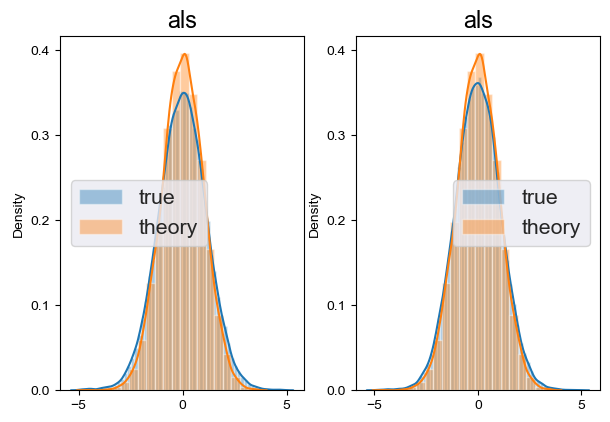

In [3]:
d1 = d2 = 500
alpha = 0.1
sd = 1
het = 'homo' # 'homo' | 'logis' | 'rank1'
pr = 0.8
rk = 20
k_star = 6
M_mean = 2
mis_set = 1
sigma_true=False
full_exp=True
tail = 'gaussian'
kap = 1
res = simu_synthetic(d1,d2,alpha,het,sd,tail,pr,k_star,rk,M_mean,mis_set,kap,sigma_true,plot=True,full_exp=full_exp)
print(res)

In [3]:
# repeated
# remember to disable plotting
alpha = 0.1
sd0 = 1
het = 'homo' # 'homo' | 'logis' | 'rank1'
base1 = 'cvx'
base2 = base = 'als'
repN = 100
M_mean = 2
kap = 1
k_star = 8
sigma_true=False
full_exp = False
num_cores = mp.cpu_count()
rk_seq = range(2,41,2)
# rk_seq = range(4,25,4)

for d in [500]:
    d1 = d2 = d
    for pr in [0.8]:
        for tail in ['gaussian']:
            for mis_set in [3]:
                for rk in rk_seq:
                    if mis_set==2:
                        pr = 0.2
                    else:
                        pr = 0.8
                    if mis_set==3:
                        tail='t'
                        sd = 0.2
                    else:
                        tail='gaussian'
                        sd = sd0
                    print([mis_set, tail, sd])
                    if __name__ == "__main__":
                        results = Parallel(n_jobs=num_cores)(delayed(simu_synthetic)(d1,d2,alpha,het,sd,tail,pr,k_star,rk,M_mean,mis_set,kap,sigma_true,full_exp=full_exp) for i in range(repN))
                    results = np.array(results)
                        
                    if full_exp:
                        res_mat = results.reshape(repN,8)
                        cov_rt_cf_cvx = res_mat[:,0]
                        cov_rt_cf_als = res_mat[:,1]
                        cov_rt_cvx = res_mat[:,2]
                        cov_rt_als = res_mat[:,3]
                        cov_ = np.hstack((cov_rt_cf_cvx, cov_rt_cf_als))
                        cov_ = np.hstack((cov_,cov_rt_cvx))
                        cov_ = np.hstack((cov_,cov_rt_als))
                        len_ave_cf_cvx = res_mat[:,4]
                        len_ave_cf_als = res_mat[:,5]
                        len_ave_cvx = res_mat[:,6]
                        len_ave_als = res_mat[:,7]
                        len_ = np.hstack((len_ave_cf_cvx, len_ave_cf_als))
                        len_ = np.hstack((len_,len_ave_cvx))
                        len_ = np.hstack((len_,len_ave_als))

                        label1 = 'cf-'+base1
                        label2 = 'cf-'+base2
                        label3 = 'cvx'
                        label4 = 'als'
                        nam_ = [label1]*repN + [label2]*repN + [label3]*repN + [label4]*repN
                        cov_df = pd.DataFrame(cov_, columns=['coverage'])
                        len_df = pd.DataFrame(len_, columns=['length'])
                        cov_df['approach'] = nam_
                        len_df['approach'] = nam_
                        
                    else:
                        res_mat = results.reshape(repN,4)
                        cov_rt_cf_als = res_mat[:,0]
                        cov_rt_als = res_mat[:,1]
                        cov_ = np.hstack((cov_rt_cf_als,cov_rt_als))
                        len_ave_cf_als = res_mat[:,2]
                        len_ave_als = res_mat[:,3]
                        len_ = np.hstack((len_ave_cf_als,len_ave_als))

                        label1 = 'cf-'+base2
                        label2 = 'als'
                        nam_ = [label1]*repN + [label2]*repN
                        cov_df = pd.DataFrame(cov_, columns=['coverage'])
                        len_df = pd.DataFrame(len_, columns=['length'])
                        cov_df['approach'] = nam_
                        len_df['approach'] = nam_

                    file_dir1 = '../results/cov_'+str(d1)+'_'+str(mis_set)+'_'+str(k_star)+'_'+str(rk)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(sigma_true)+'_'+str(full_exp)+'.csv'
                    file_dir2 = '../results/len_'+str(d1)+'_'+str(mis_set)+'_'+str(k_star)+'_'+str(rk)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(sigma_true)+'_'+str(full_exp)+'.csv'
                    cov_df.to_csv(file_dir1, index=False)
                    len_df.to_csv(file_dir2, index=False)

#                     fig, ax = plt.subplots(ncols=2,figsize=(8,3))     
#                     fig.tight_layout(pad=0.6)
#                     sns.set(font_scale = 1.4)

#                     sns.boxplot(ax=ax[0], data=cov_df, y="coverage", x="approach",showfliers = False)
#                     ax[0].axhline(y = 1-alpha, color = 'r', linestyle = '--')

#                     sns.boxplot(ax=ax[1], data=len_df, y="length", x="approach",showfliers = False)

#                     ax[1].set_ylim(0,max(len_df['length']))

#                     plot_dir = '../plots/robust_'+str(alpha)+'_'+str(d1)+'_'+str(mis_set)+'_'+str(rk)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(sigma_true)+'_'+str(full_exp)+'.pdf'
#                     plt.savefig(plot_dir, bbox_inches='tight')

                    



[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]
[3, 't', 0.2]


In [7]:
# # plot
# alpha = 0.1
# sd = 1e-1
# if sd == 0:
#     sd_perturb = 1e-3
#     tail = ''
# else:
#     sd_perturb = 0
#     tail = 'gaussian'
# het = 'homo' # 'homo' | 'logis' | 'rank1'
# base = 'als'
# repN = 100
# sigma_true=False

# for d in [500]:
#     d1 = d2 = d
#     for pr in [0.8]:
#         for tail in ['cauchy']:
#             for mis_set in [0]:
#                 for rk in [2,5,10,20]:
#                     file_dir1 = '../results/cov_'+str(d1)+'_'+str(mis_set)+'_'+str(rk)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(sigma_true)+'.csv'
#                     file_dir2 = '../results/len_'+str(d1)+'_'+str(mis_set)+'_'+str(rk)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(sigma_true)+'.csv'
#     #                 file_dir1 = '../results/cov_'+str(d1)+'_'+str(low_d)+'_'+het+'_'+str(sd)+'_'+str(sd_perturb)+'_'+tail+'_'+str(pr)+'.csv'
#     #                 file_dir2 = '../results/len_'+str(d1)+'_'+str(low_d)+'_'+het+'_'+str(sd)+'_'+str(sd_perturb)+'_'+tail+'_'+str(pr)+'.csv'
#                     cov_df = pd.read_csv(file_dir1)
#                     len_df = pd.read_csv(file_dir2)

#                     label1 = 'cf*-'+base
#                     label2 = 'cf-'+base
#                     label3 = 'cvx'
#                     label4 = 'als'
#                     nam_ = [label1]*repN + [label2]*repN + [label3]*repN + [label4]*repN
#                     cov_df['approach'] = nam_
#                     len_df['approach'] = nam_

#                     fig, ax = plt.subplots(ncols=2,figsize=(8,3))     
#                     fig.tight_layout(pad=0.6)
#                     sns.set(font_scale = 1.4)

#                     sns.boxplot(ax=ax[0], data=cov_df, y="coverage", x="approach",showfliers = False)
#                     ax[0].axhline(y = 1-alpha, color = 'r', linestyle = '--')
#                     ax[0].set_ylim((0.8,1))
#     #                 ax[0].set_xlabel('approach', fontsize=14)
#     #                 ax[0].set_ylabel('coverage rate', fontsize=14)
#                     # ax[0].set_title('$d_1=d_2=$'+str(d1)+', pr='+str(pr)+', sd='+str(sd)+', sd_ptb='+str(sd_perturb))
#                     # ax[0].set_title('$d_1=d_2=$'+str(d1)+', pr='+str(pr)+', sd='+str(sd)+', tail='+tail)

#                     sns.boxplot(ax=ax[1], data=len_df, y="length", x="approach",showfliers = False)

#                     ax[1].set_ylim(0,max(len_df['length'])*1.05)
#     #                 ax[1].set_xlabel('approach', fontsize=14)
#     #                 ax[1].set_ylabel('average length', fontsize=14)


#                     plot_dir = '../plots/robust_'+str(alpha)+'_'+str(d1)+'_'+str(mis_set)+'_'+str(rk)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(sigma_true)+'.pdf'
#                     plt.savefig(plot_dir, bbox_inches='tight')

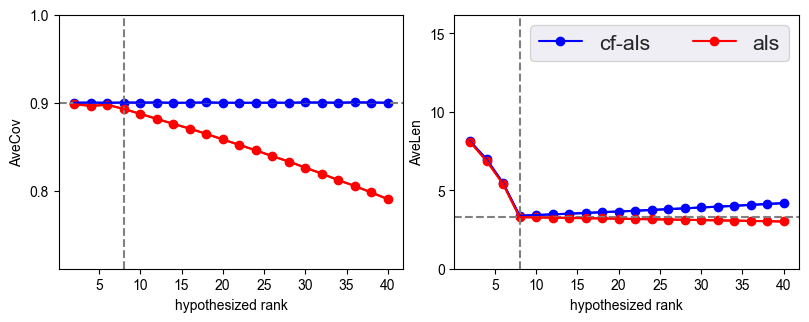

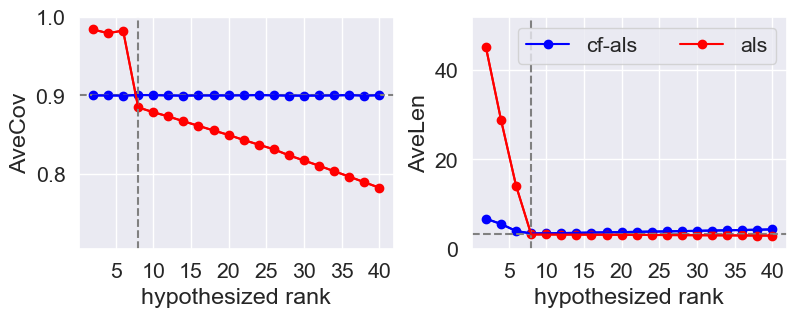

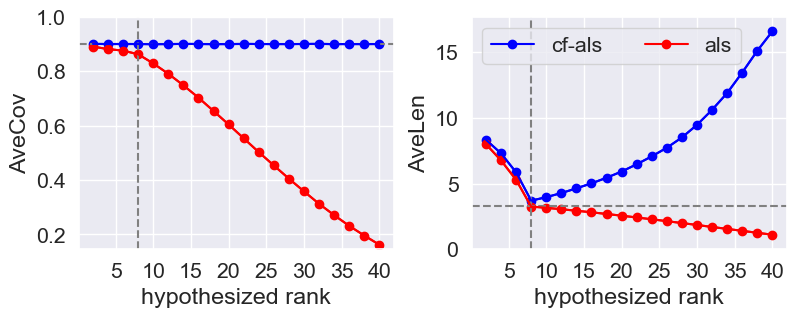

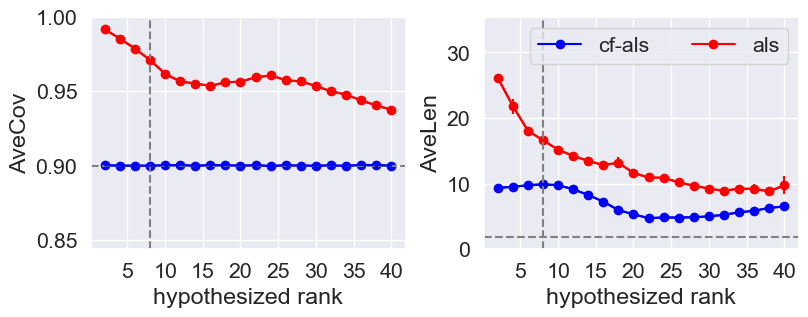

In [4]:
import scipy.stats
# plot
alpha = 0.1
sd0 = 1
het = 'homo' # 'homo' | 'logis' | 'rank1'
base1 = 'cvx'
base2 = 'als'
repN = 100
sigma_true=False
full_exp=False
rk_seq = range(2,41,2)
k_star = 8

for d in [500]:
    d1 = d2 = d
    for pr0 in [0.8]:
        for mis_set in [0,1,2,3]:
            if mis_set==2:
                pr = 0.2
            else:
                pr = pr0
            if mis_set==3:
                tail='t'
                sd = 0.2
            else:
                tail='gaussian'
                sd = sd0
            cov_conf = np.zeros(len(rk_seq))
            cov_conf_hat = np.zeros(len(rk_seq))
            cov_als = np.zeros(len(rk_seq))
            cov_cvx = np.zeros(len(rk_seq))
            len_conf = np.zeros(len(rk_seq))
            len_conf_hat = np.zeros(len(rk_seq))
            len_als = np.zeros(len(rk_seq))
            len_cvx = np.zeros(len(rk_seq))

            sd_cov_conf = np.zeros(len(rk_seq))
            sd_cov_conf_hat = np.zeros(len(rk_seq))
            sd_cov_als = np.zeros(len(rk_seq))
            sd_cov_cvx = np.zeros(len(rk_seq))
            sd_len_conf = np.zeros(len(rk_seq))
            sd_len_conf_hat = np.zeros(len(rk_seq))
            sd_len_als = np.zeros(len(rk_seq))
            sd_len_cvx = np.zeros(len(rk_seq))
            for i_rk in range(len(rk_seq)):
                rk = rk_seq[i_rk]
                file_dir1 = '../results/cov_'+str(d1)+'_'+str(mis_set)+'_'+str(k_star)+'_'+str(rk)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(sigma_true)+'_'+str(full_exp)+'.csv'
                file_dir2 = '../results/len_'+str(d1)+'_'+str(mis_set)+'_'+str(k_star)+'_'+str(rk)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(sigma_true)+'_'+str(full_exp)+'.csv'
#                 file_dir1 = '../results/cov_'+str(d1)+'_'+str(low_d)+'_'+het+'_'+str(sd)+'_'+str(sd_perturb)+'_'+tail+'_'+str(pr)+'.csv'
#                 file_dir2 = '../results/len_'+str(d1)+'_'+str(low_d)+'_'+het+'_'+str(sd)+'_'+str(sd_perturb)+'_'+tail+'_'+str(pr)+'.csv'
                cov_df = pd.read_csv(file_dir1)
                len_df = pd.read_csv(file_dir2)


                label1 = 'cf-'+base1
                label2 = 'cf-'+base2
                label3 = base1
                label4 = base2
                nam_ = [label2]*repN + [label4]*repN # + [label3]*repN + [label4]*repN
                cov_df['approach'] = nam_
                len_df['approach'] = nam_

#                 cov_conf[i_rk] = cov_df[cov_df['approach']==label1].mean(axis=0)[0]
                cov_conf_hat[i_rk] = cov_df[cov_df['approach']==label2].mean(axis=0)[0]
#                 cov_cvx[i_rk] = cov_df[cov_df['approach']==label3].mean(axis=0)[0]
                cov_als[i_rk] = cov_df[cov_df['approach']==label4].mean(axis=0)[0]
#                 sd_cov_conf[i_rk] = cov_df[cov_df['approach']==label1].sem(axis=0)[0]
                sd_cov_conf_hat[i_rk] = cov_df[cov_df['approach']==label2].sem(axis=0)[0]
#                 sd_cov_cvx[i_rk] = cov_df[cov_df['approach']==label3].sem(axis=0)[0]
                sd_cov_als[i_rk] = cov_df[cov_df['approach']==label4].sem(axis=0)[0]

#                 len_conf[i_rk] = len_df[len_df['approach']==label1].mean(axis=0)[0]
                len_conf_hat[i_rk] = len_df[len_df['approach']==label2].mean(axis=0)[0]
#                 len_cvx[i_rk] = len_df[len_df['approach']==label3].mean(axis=0)[0]
                len_als[i_rk] = len_df[len_df['approach']==label4].mean(axis=0)[0]
#                 sd_len_conf[i_rk] = len_df[len_df['approach']==label1].sem(axis=0)[0]
                sd_len_conf_hat[i_rk] = len_df[len_df['approach']==label2].sem(axis=0)[0]
#                 sd_len_cvx[i_rk] = len_df[len_df['approach']==label3].sem(axis=0)[0]
                sd_len_als[i_rk] = len_df[len_df['approach']==label4].sem(axis=0)[0]


            fig, ax = plt.subplots(ncols=2,figsize=(8,3))     
            fig.tight_layout(pad=0.6)
            sns.set(font_scale = 1.4)

            col_seq=['orange','blue','green','red']
            ymax = max(len_conf_hat+len_als)
            cov_min = min(min(cov_als)*0.9,1-alpha)

#             ax[0].plot(range(len(rk_seq)), cov_conf, marker='o', label=label1, c=col_seq[0])
#             ax[0].errorbar(range(len(rk_seq)), cov_conf, yerr = sd_cov_conf, c=col_seq[0])
            ax[0].plot(range(len(rk_seq)), cov_conf_hat, marker='o', label=label2, c=col_seq[1])
            ax[0].errorbar(range(len(rk_seq)), cov_conf_hat, yerr = sd_cov_conf_hat, c=col_seq[1])
#             ax[0].plot(range(len(rk_seq)), cov_cvx, marker='o', label=label3, c=col_seq[2])
#             ax[0].errorbar(range(len(rk_seq)), cov_cvx, yerr = sd_cov_cvx, c=col_seq[2])
            ax[0].plot(range(len(rk_seq)), cov_als, marker='o', label=label4, c=col_seq[3])
            ax[0].errorbar(range(len(rk_seq)), cov_als, yerr = sd_cov_als, c=col_seq[3])
            ax[0].set_xticks([1.5,4,6.5,9,11.5,14,16.5,19],[5,10,15,20,25,30,35,40])
            ax[0].set_ylim((cov_min,1))
            ax[0].set_xlabel('hypothesized rank')
            ax[0].set_ylabel('AveCov')
            ax[0].axvline(x = 3, color = 'grey', linestyle = '--')
            ax[0].axhline(y = 1-alpha, color = 'grey', linestyle = '--')

#             ax[1].plot(range(len(rk_seq)), len_conf, marker='o', label=label1, c=col_seq[0])
#             ax[1].errorbar(range(len(rk_seq)), len_conf, yerr = sd_len_conf, c=col_seq[0])
            ax[1].plot(range(len(rk_seq)), len_conf_hat, marker='o', label=label2, c=col_seq[1])
            ax[1].errorbar(range(len(rk_seq)), len_conf_hat, yerr = sd_len_conf_hat, c=col_seq[1])
#             ax[1].plot(range(len(rk_seq)), len_cvx, marker='o', label=label3, c=col_seq[2])
#             ax[1].errorbar(range(len(rk_seq)), len_cvx, yerr = sd_len_cvx, c=col_seq[2])
            ax[1].plot(range(len(rk_seq)), len_als, marker='o', label=label4, c=col_seq[3])
            ax[1].errorbar(range(len(rk_seq)), len_als, yerr = sd_len_als, c=col_seq[3])
            ax[1].set_xticks([1.5,4,6.5,9,11.5,14,16.5,19],[5,10,15,20,25,30,35,40])
            ax[1].set_xlabel('hypothesized rank')
            ax[1].set_ylabel('AveLen')
            ax[1].set_ylim((0,ymax))
            ax[1].legend(loc='best',ncol=2)
            ax[1].axvline(x = 3, color = 'grey', linestyle = '--')
            if tail=='gaussian':
                oracle_len = scipy.stats.norm.ppf(1-alpha/2,0,sd)
            elif tail=='t':
                oracle_len = sd * scipy.stats.t.ppf(1-alpha/2,1.2)
            ax[1].axhline(y = 2*oracle_len, color = 'grey', linestyle = '--')

            plot_dir = '../plots/plot_rk_'+str(alpha)+'_'+str(d1)+'_'+str(mis_set)+'_'+str(k_star)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(sigma_true)+'_'+str(full_exp)+'.pdf'
            plt.savefig(plot_dir, bbox_inches='tight')